## 1. Import Libraries and Setup

In [4]:
import sys
import os
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from structured_products import Autocallable, ReverseConvertible, BarrierOption, RangeAccrual
from structured_products.pricing_engine import PricingEngine

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Define Client Profiles

Let's create different client profiles with varying risk appetites and investment goals.

In [5]:
class ClientProfile:
    def __init__(self, name, risk_tolerance, investment_horizon, capital_preservation, yield_requirement, market_view):
        self.name = name
        self.risk_tolerance = risk_tolerance  # 1-10 scale
        self.investment_horizon = investment_horizon  # years
        self.capital_preservation = capital_preservation  # 0-1 scale
        self.yield_requirement = yield_requirement  # annual yield
        self.market_view = market_view  # 'bullish', 'bearish', 'neutral'

# Define sample client profiles
clients = [
    ClientProfile("Conservative Investor", 2, 3, 0.95, 0.04, "neutral"),
    ClientProfile("Balanced Investor", 5, 5, 0.85, 0.06, "bullish"),
    ClientProfile("Growth-Oriented", 8, 7, 0.70, 0.08, "bullish"),
    ClientProfile("Income Seeker", 3, 4, 0.90, 0.07, "neutral")
]

print("Client profiles defined:")
for client in clients:
    print(f"- {client.name}: Risk={client.risk_tolerance}/10, Horizon={client.investment_horizon}y, Yield={client.yield_requirement:.1%}")

Client profiles defined:
- Conservative Investor: Risk=2/10, Horizon=3y, Yield=4.0%
- Balanced Investor: Risk=5/10, Horizon=5y, Yield=6.0%
- Growth-Oriented: Risk=8/10, Horizon=7y, Yield=8.0%
- Income Seeker: Risk=3/10, Horizon=4y, Yield=7.0%


## 3. Product Recommendation Engine

Create a function that recommends structured products based on client profiles.

In [11]:
def recommend_products(client):
    """
    Recommend structured products based on client profile.
    
    Returns:
        List of (product, score, reasoning) tuples
    """
    recommendations = []
    
    # Market parameters
    spot = 100
    vol = 0.20
    r = 0.025
    
    # Autocallable - Good for conservative investors seeking yield
    if client.capital_preservation >= 0.8 and client.yield_requirement >= 0.03:
        autocall = Autocallable(
            spot=spot, strike=spot, barrier=85, coupon=client.yield_requirement,
            maturity=client.investment_horizon, autocall_levels=[105, 110, 115, 120]
        )
        score = (10 - client.risk_tolerance) * 0.3 + client.capital_preservation * 0.4 + 0.3
        reasoning = f"Provides {client.yield_requirement:.1%} coupons with capital protection. Suitable for {client.market_view} market view."
        recommendations.append((autocall, score, reasoning, "Autocallable"))
    
    # Reverse Convertible - Good for yield-seeking investors
    if client.yield_requirement >= 0.06 and client.risk_tolerance >= 4:
        rev_conv = ReverseConvertible(
            spot=spot, strike=spot, coupon=client.yield_requirement,
            maturity=client.investment_horizon, capital_protection=client.capital_preservation
        )
        score = client.yield_requirement * 10 + client.risk_tolerance * 0.2 - (1-client.capital_preservation) * 0.3
        reasoning = f"Offers enhanced {client.yield_requirement:.1%} yield with {client.capital_preservation:.0%} capital protection."
        recommendations.append((rev_conv, score, reasoning, "Reverse Convertible"))
    
    # Barrier Option - Good for sophisticated investors
    if client.risk_tolerance >= 6:
        barrier = BarrierOption(
            spot=spot, strike=spot, barrier=90 if client.market_view == 'bullish' else 110,
            maturity=client.investment_horizon, option_type='call',
            barrier_type='up_and_in' if client.market_view == 'bullish' else 'down_and_in'
        )
        score = client.risk_tolerance * 0.4 + (0.5 if client.market_view in ['bullish', 'bearish'] else 0.2)
        reasoning = f"Leveraged exposure with barrier protection. Matches {client.market_view} market outlook."
        recommendations.append((barrier, score, reasoning, "Barrier Option"))
    
    # Range Accrual - Good for income in stable markets
    if client.market_view == 'neutral' and client.yield_requirement >= 0.03:
        ranges = [(90, 110)] * int(client.investment_horizon)  # Stable range
        coupons = [client.yield_requirement] * len(ranges)
        range_accrual = RangeAccrual(
            spot=spot, strike=spot, ranges=ranges, coupon_rates=coupons,
            maturity=client.investment_horizon
        )
        score = (10 - client.risk_tolerance) * 0.2 + client.yield_requirement * 8 + 0.2
        reasoning = f"Provides income when market stays within ranges. Ideal for neutral market conditions."
        recommendations.append((range_accrual, score, reasoning, "Range Accrual"))
    
    # Sort by score
    recommendations.sort(key=lambda x: x[1], reverse=True)
    return recommendations

# Test recommendations
for client in clients:
    print(f"\n{client.name} Recommendations:")
    recs = recommend_products(client)
    for product, score, reasoning, name in recs[:2]:  # Top 2
        print(f"  {name}: Score {score:.1f}/10")
        print(f"    {reasoning}")


Conservative Investor Recommendations:
  Autocallable: Score 3.1/10
    Provides 4.0% coupons with capital protection. Suitable for neutral market view.
  Range Accrual: Score 2.1/10
    Provides income when market stays within ranges. Ideal for neutral market conditions.

Balanced Investor Recommendations:
  Autocallable: Score 2.1/10
    Provides 6.0% coupons with capital protection. Suitable for bullish market view.
  Reverse Convertible: Score 1.6/10
    Offers enhanced 6.0% yield with 85% capital protection.

Growth-Oriented Recommendations:
  Barrier Option: Score 3.7/10
    Leveraged exposure with barrier protection. Matches bullish market outlook.
  Reverse Convertible: Score 2.3/10
    Offers enhanced 8.0% yield with 70% capital protection.

Income Seeker Recommendations:
  Autocallable: Score 2.8/10
    Provides 7.0% coupons with capital protection. Suitable for neutral market view.
  Range Accrual: Score 2.2/10
    Provides income when market stays within ranges. Ideal for 

## 4. Comparative Analysis Function

Create a function to compare products side-by-side.

In [7]:
def compare_products(products, product_names, n_sim=5000):
    """
    Compare multiple products with pricing and risk metrics.
    
    Args:
        products: List of structured product instances
        product_names: List of product names
        n_sim: Number of Monte Carlo simulations
    
    Returns:
        DataFrame with comparison metrics
    """
    results = []
    
    for product, name in zip(products, product_names):
        # Price the product
        price = product.price_mc(n_sim=n_sim)
        
        # Calculate Greeks
        greeks = product.calculate_greeks(n_sim=n_sim)
        
        # Scenario analysis
        scenarios = {
            'spot': [-0.1, 0, 0.1],  # -10%, 0%, +10%
            'vol': [-0.2, 0, 0.2],   # -20%, 0%, +20%
        }
        scenario_prices = product.scenario_analysis(scenarios)
        
        # Risk metrics (simplified)
        payoffs = []
        for _ in range(n_sim//10):  # Fewer sims for speed
            payoff = product.price_mc(n_sim=10)
            payoffs.append(payoff)
        payoffs = np.array(payoffs)
        
        var_95 = PricingEngine.calculate_var(payoffs, 0.95)
        cvar_95 = PricingEngine.calculate_cvar(payoffs, 0.95)
        
        results.append({
            'Product': name,
            'Price': price,
            'Delta': greeks['delta'],
            'Gamma': greeks['gamma'],
            'Vega': greeks['vega'],
            'Theta': greeks['theta'],
            'VaR_95': var_95,
            'CVaR_95': cvar_95,
            'Worst_Scenario': min(scenario_prices.values()),
            'Best_Scenario': max(scenario_prices.values())
        })
    
    return pd.DataFrame(results)

# Example comparison
conservative_client = clients[0]
recs = recommend_products(conservative_client)
products = [rec[0] for rec in recs[:3]]  # Top 3 products
names = [rec[3] for rec in recs[:3]]

comparison_df = compare_products(products, names)
print("Product Comparison for Conservative Investor:")
comparison_df.round(4)

Product Comparison for Conservative Investor:


""


## 5. Pitch Generation

Create a comprehensive pitch for a specific client and product.

In [12]:
def generate_pitch(client, product, product_name):
    """
    Generate a comprehensive pitch for a client-product combination.
    
    Args:
        client: ClientProfile instance
        product: Structured product instance
        product_name: Name of the product
    
    Returns:
        Dictionary with pitch components
    """
    # Price and risk metrics
    price = product.price_mc(n_sim=10000)
    greeks = product.calculate_greeks()
    
    # Key benefits
    benefits = []
    if hasattr(product, 'coupon'):
        benefits.append(f"Annual coupon of {product.coupon:.1%}")
    if hasattr(product, 'capital_protection') and product.capital_protection > 0:
        benefits.append(f"{product.capital_protection:.0%} capital protection")
    if hasattr(product, 'autocall_levels'):
        benefits.append(f"Potential early redemption at {product.autocall_levels[0]}")
    
    # Risk considerations
    risks = []
    if hasattr(product, 'barrier'):
        risks.append(f"Barrier at {product.barrier} could affect payoff")
    if product_name == "Reverse Convertible":
        risks.append("Full downside exposure below strike")
    risks.append(f"Market risk with volatility of {product.vol:.1%}")
    
    # Comparative advantage
    vanilla_option_price = PricingEngine.black_scholes_price(
        product.spot, product.strike, product.maturity, product.r, product.vol, 'call'
    )
    
    pitch = {
        'client_name': client.name,
        'product_name': product_name,
        'investment_amount': f"${product.spot:,.0f}",
        'expected_return': f"{price*100/product.spot:.1f}% annual return",
        'key_benefits': benefits,
        'risk_considerations': risks,
        'vs_vanilla_option': f"{price/vanilla_option_price:.1f}x pricing vs vanilla call",
        'greeks_summary': f"Delta: {greeks['delta']:.2f}, Vega: {greeks['vega']:.2f}",
        'recommendation': f"{'Strongly recommend' if client.risk_tolerance <= 5 else 'Consider'} for {client.market_view} market outlook"
    }
    
    return pitch

# Generate pitch for conservative client
client = clients[0]
product, _, _, product_name = recommend_products(client)[0]  # Best recommendation

pitch = generate_pitch(client, product, product_name)

print("=== STRUCTURED PRODUCT PITCH ===")
print(f"Client: {pitch['client_name']}")
print(f"Recommended Product: {pitch['product_name']}")
print(f"Investment: {pitch['investment_amount']}")
print(f"Expected Annual Return: {pitch['expected_return']}")
print("\nKey Benefits:")
for benefit in pitch['key_benefits']:
    print(f"• {benefit}")
print("\nRisk Considerations:")
for risk in pitch['risk_considerations']:
    print(f"• {risk}")
print(f"\nPricing vs Alternatives: {pitch['vs_vanilla_option']}")
print(f"Greeks: {pitch['greeks_summary']}")
print(f"\nRecommendation: {pitch['recommendation']}")

=== STRUCTURED PRODUCT PITCH ===
Client: Conservative Investor
Recommended Product: Autocallable
Investment: $100
Expected Annual Return: 0.8% annual return

Key Benefits:
• Annual coupon of 4.0%
• 100% capital protection
• Potential early redemption at 105

Risk Considerations:
• Barrier at 85 could affect payoff
• Market risk with volatility of 20.0%

Pricing vs Alternatives: 0.1x pricing vs vanilla call
Greeks: Delta: 0.12, Vega: -0.84

Recommendation: Strongly recommend for neutral market outlook


## 6. Visualization: Risk-Return Scatter Plot

Create a visualization comparing risk-return profiles of different products.

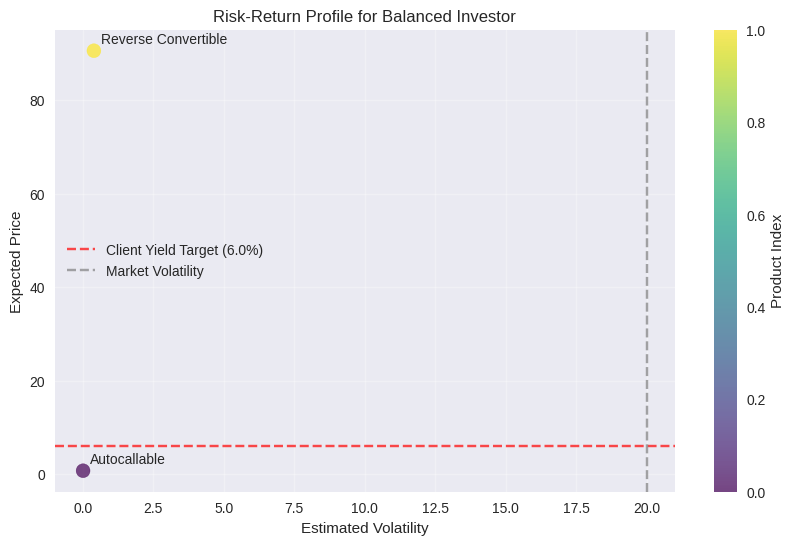

In [18]:
def plot_risk_return_comparison(products, names, client):
    """
    Plot risk-return scatter plot for product comparison.
    """
    prices = []
    volatilities = []
    
    for product in products:
        price = product.price_mc(n_sim=2000)
        prices.append(price)
        
        # Estimate volatility from scenarios
        scenarios = {'vol_down': {'vol': -0.1}, 'vol_base': {'vol': 0}, 'vol_up': {'vol': 0.1}}
        scenario_prices = product.scenario_analysis(scenarios)
        vol_est = np.std([scenario_prices['vol_down'], scenario_prices['vol_base'], scenario_prices['vol_up']])
        volatilities.append(vol_est)
    
    plt.figure(figsize=(10, 6))
    
    # Plot products
    scatter = plt.scatter(volatilities, prices, s=100, c=range(len(products)), cmap='viridis', alpha=0.7)
    
    # Add labels
    for i, name in enumerate(names):
        plt.annotate(name, (volatilities[i], prices[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=10)
    
    # Add market benchmarks
    spot = 100  # Default spot price
    plt.axhline(y=client.yield_requirement * spot, color='red', linestyle='--', alpha=0.7, 
                label=f'Client Yield Target ({client.yield_requirement:.1%})')
    plt.axvline(x=spot * 0.2, color='gray', linestyle='--', alpha=0.7,
                label='Market Volatility')
    
    plt.xlabel('Estimated Volatility')
    plt.ylabel('Expected Price')
    plt.title(f'Risk-Return Profile for {client.name}')
    plt.colorbar(scatter, label='Product Index')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Plot for balanced investor
balanced_client = clients[1]
recs = recommend_products(balanced_client)
products = [rec[0] for rec in recs[:4]]
names = [rec[3] for rec in recs[:4]]

plot_risk_return_comparison(products, names, balanced_client)